In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('political_data.csv')
data['cleaned_text'] = data['text'].str.lower().str.replace('[^\w\s]', '')
# data.shape

In [ ]:
import pandas as pd

cleaned_df = data[(data['text'].str.len() >= 20)]

cleaned_df.to_csv('cleaned_dataset.csv', index=False)

cleaned_df.shape

(500, 9)

In [ ]:
data = cleaned_df
print(data.shape)
print(data['expected_political_leaning'].value_counts())

(500, 9)
expected_political_leaning
lib    250
con    250
Name: count, dtype: int64


In [ ]:
df_negs = data[data['score'] <= 0]
df_negs.shape
data['expected_political_leaning'].value_counts

<bound method IndexOpsMixin.value_counts of 2349    lib
2350    lib
2351    lib
2352    lib
2353    lib
       ... 
2844    con
2845    con
2846    con
2847    con
2848    con
Name: expected_political_leaning, Length: 500, dtype: object>

In [ ]:
from gensim.models import Word2Vec

sentences = [text.split() for text in data['cleaned_text']]

model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

data['embedding'] = data['cleaned_text'].apply(
    lambda x: np.mean([model.wv[word] for word in x.split() if word in model.wv], axis=0)
    if any(word in model.wv for word in x.split())
    else np.zeros(model.vector_size)
)


In [ ]:
data['upvote_weight'] = np.log1p(data['score'])
# data['weighted_embedding'] = data.apply(lambda row: row['embedding'] * row['upvote_weight'], axis=1)
data['weighted_embedding'] = data['embedding']

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
data.head()

,text,subreddit,post_or_comment,expected_political_leaning,score,cleaned_text,embedding,upvote_weight,weighted_embedding
2349,kamala hq share video trump talking … somethin...,KamalaHarris,post,lib,4128,kamala hq share video trump talking … somethin...,"[0.001256367, 0.0004907154, -0.0013743277, 0.0...",8.325791,"[0.001256367, 0.0004907154, -0.0013743277, 0.0..."
2350,know town hall there lot people fake news like...,KamalaHarris,comment,lib,989,know town hall there lot people fake news like...,"[-0.0010095402, 0.004541139, -0.0012746166, 0....",6.897705,"[-0.0010095402, 0.004541139, -0.0012746166, 0...."
2351,literally said people coming silence lamb wtf ...,KamalaHarris,comment,lib,246,literally said people coming silence lamb wtf ...,"[-0.00074038486, 0.0021134939, -0.00015405318,...",5.509388,"[-0.00074038486, 0.0021134939, -0.00015405318,..."
2352,♥️ mentioned everybody stay till end shes livi...,KamalaHarris,comment,lib,142,♥️ mentioned everybody stay till end shes livi...,"[0.0023844335, 0.0061563207, 0.00062481227, 0....",4.962845,"[0.0023844335, 0.0061563207, 0.00062481227, 0...."
2353,rambling mess dont know half shit he talking w...,KamalaHarris,comment,lib,87,rambling mess dont know half shit he talking w...,"[-0.0024008744, 0.00047980572, -0.0019203213, ...",4.477337,"[-0.0024008744, 0.00047980572, -0.0019203213, ..."


In [ ]:
# ! pip install faiss-gpu

In [ ]:
import faiss
embeddings_matrix = np.vstack(data['weighted_embedding'].values).astype('float32')
embeddings_matrix = np.ascontiguousarray(embeddings_matrix)

d = embeddings_matrix.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings_matrix)

In [ ]:
from scipy.spatial.distance import cosine

def find_similar_texts(query_text, k=11):
    query_embedding = model.wv[query_text.split()].mean(axis=0).astype('float32')

    _, closest_indices = index.search(query_embedding.reshape(1, -1), k)

    closest_texts = data.iloc[closest_indices[0]]
    # print(closest_texts)

    democrat_count = closest_texts[closest_texts['expected_political_leaning'] == 'lib'].shape[0]
    republican_count = closest_texts[closest_texts['expected_political_leaning'] == 'con'].shape[0]

    return closest_texts, 'lib' if democrat_count > republican_count else 'con'


In [ ]:
new_text = "kamala"
closest_texts, dominant_leaning = find_similar_texts(new_text)
print(f"The dominant leaning among the closest texts is: {dominant_leaning}")

The dominant leaning among the closest texts is: lib


In [ ]:
data.head()

,text,subreddit,post_or_comment,expected_political_leaning,score,cleaned_text,embedding,upvote_weight,weighted_embedding
2349,kamala hq share video trump talking … somethin...,KamalaHarris,post,lib,4128,kamala hq share video trump talking … somethin...,"[0.001256367, 0.0004907154, -0.0013743277, 0.0...",8.325791,"[0.001256367, 0.0004907154, -0.0013743277, 0.0..."
2350,know town hall there lot people fake news like...,KamalaHarris,comment,lib,989,know town hall there lot people fake news like...,"[-0.0010095402, 0.004541139, -0.0012746166, 0....",6.897705,"[-0.0010095402, 0.004541139, -0.0012746166, 0...."
2351,literally said people coming silence lamb wtf ...,KamalaHarris,comment,lib,246,literally said people coming silence lamb wtf ...,"[-0.00074038486, 0.0021134939, -0.00015405318,...",5.509388,"[-0.00074038486, 0.0021134939, -0.00015405318,..."
2352,♥️ mentioned everybody stay till end shes livi...,KamalaHarris,comment,lib,142,♥️ mentioned everybody stay till end shes livi...,"[0.0023844335, 0.0061563207, 0.00062481227, 0....",4.962845,"[0.0023844335, 0.0061563207, 0.00062481227, 0...."
2353,rambling mess dont know half shit he talking w...,KamalaHarris,comment,lib,87,rambling mess dont know half shit he talking w...,"[-0.0024008744, 0.00047980572, -0.0019203213, ...",4.477337,"[-0.0024008744, 0.00047980572, -0.0019203213, ..."


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

true_labels = []
predicted_labels = []

for _, row in data.iterrows():
    if _ % 1000 == 0:
        print(_)
    # if _ != 0 and _ % 5000 == 0:
    #     break
    query_text = row['cleaned_text']
    true_label = row['expected_political_leaning']

    # Run the find_similar_texts function
    _, predicted_label = find_similar_texts(query_text)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['lib', 'con'])

conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Lib', 'Actual Con'], columns=['Predicted Lib', 'Predicted Con'])

In [ ]:
# accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.684


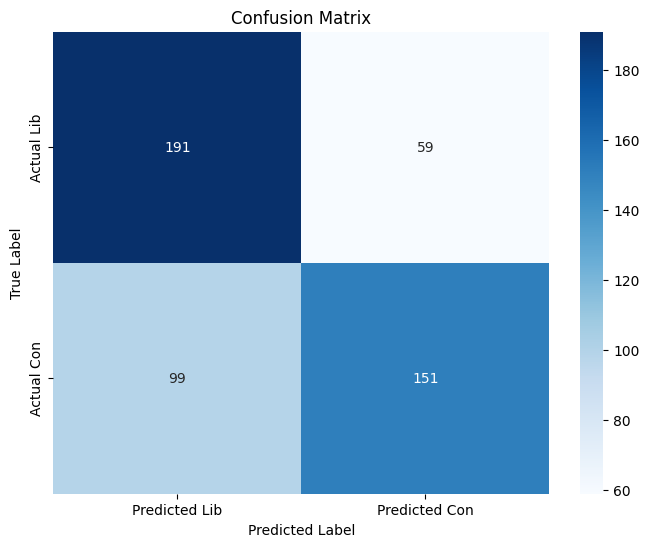

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_labels, predicted_labels, pos_label='lib')
recall = recall_score(true_labels, predicted_labels, pos_label='lib')
f1 = f1_score(true_labels, predicted_labels, pos_label='lib')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Precision: 0.6586206896551724
Recall: 0.764
F1-score: 0.7074074074074074


In [ ]:
data['expected_political_leaning'].value_counts()

,count
expected_political_leaning,
lib,250
con,250


In [ ]:
data = data[250:-250]
